In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import sys
import os
from pathlib import Path

In [5]:
BASE_PATH = Path(os.path.abspath('')).parent.parent.parent
sys.path.append(str(BASE_PATH))

In [12]:
from bandits.algorithms import *
from bandits.reward_functions import *
from replay_engines.backtester import run_bandit_network_backtest, run_backtest
# from backtest.portfolio_results import calculate_classical_portfolios
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import scienceplots

import datetime
import yfinance as yf
import re
import pandas as pd
from pandas import DataFrame
import numpy as np

import random

%matplotlib inline

# plt.style.use(['science','ieee'])
# plt.style.use(['science','nature'])

In [141]:
import pandas_datareader.data as web

# Load the 48 industry portfolios
data = web.DataReader('48_Industry_Portfolios', 'famafrench', start="1930-01-01")

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_74332/1072282762.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = web.DataReader('48_Industry_Portfolios', 'famafrench', start="1930-01-01")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_74332/1072282762.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = web.DataReader('48_Industry_Portfolios', 'famafrench', start="1930-01-01")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_74332/1072282762.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_

In [142]:
data[0].to_csv('48_Industry_Portfolios_v4.csv')

In [86]:
portfolio = pd.read_csv('48_Industry_Portfolios.csv')
portfolio = portfolio.fillna(0.)
portfolio["Date"] = pd.to_datetime(portfolio["Date"], utc=True).dt.date
portfolio = portfolio.set_index("Date")

In [87]:
portfolio

Agric  Food   Soda   Beer   Smoke  Toys   Fun    Books  Hshld  \
Date                                                                        
1970-01-01   1.04  -2.77  -2.75  -1.36  -6.99  -8.02  -5.63 -11.40  -6.89   
1970-02-01   9.94   5.99   3.86   6.86   0.29   6.03   8.22   0.52   0.26   
1970-03-01 -13.39  -0.56  -1.09  -0.62   1.42  -2.82  -2.54  -2.70  -0.96   
1970-04-01 -17.65 -10.54  -8.67  -9.40  -2.81 -19.92 -21.50 -15.05  -7.92   
1970-05-01 -10.95  -8.61  -3.65  -6.10   3.53  -7.92 -13.15 -17.57  -8.22   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2024-07-01   5.11   4.06   3.57   3.04  11.69   8.51  -3.96   3.15  -1.07   
2024-08-01   2.32   5.09   5.38   0.88   7.96  -1.92   5.98   1.69   6.30   
2024-09-01   2.76   0.95   0.77   1.32  -1.31   3.37   4.29  -2.33   1.05   
2024-10-01   4.39  -4.28  -7.69  -5.15   8.46   0.29   4.02   0.61  -5.81   
2024-11-01   3.02   0.63   0.28  -0.40   2.15   4.00  14.15   5.40   7.01   

            Clths  ...  Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  \
Date               ...                                                    
1970-01-01  -4.79  ...  -8.47  -7.74  -7.76  -5.66 -11.92  -7.51  -8.93   
1970-02-01   2.70  ...   6.27  10.59   1.98   5.80   5.37  15.54  10.47   
1970-03-01  -0.57  ...  -2.36  -3.36  -5.31  -0.92  -7.57  -1.22  -0.23   
1970-04-01 -14.12  ... -10.72 -11.92 -20.28 -10.02 -18.41 -10.91 -15.26   
1970-05-01 -10.23  ... -10.27  -6.90 -11.66  -9.40 -12.09  -6.49  -8.72   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2024-07-01  -2.36  ...  11.79   0.20   6.44  -0.13  -2.66   7.46   8.44   
2024-08-01   5.78  ...   1.24   2.45  -1.21   0.75   5.47   2.20   4.33   
2024-09-01   5.76  ...   3.27   2.50  -0.72   4.09   5.43  -2.00  -1.02   
2024-10-01  -6.12  ...  -3.61   1.37  -1.58  -0.96  -0.64   5.12  -4.31   
2024-11-01   7.85  ...   6.22   8.43  11.84  10.25   6.25  13.21   8.33   

            RlEst  Fin    Other  
Date                             
1970-01-01 -11.35 -10.70  -5.05  
1970-02-01   1.50   9.14  -5.26  
1970-03-01  -1.00  -0.57   0.07  
1970-04-01 -18.64 -12.48 -28.64  
1970-05-01 -15.17  -9.44  -5.46  
...           ...    ...    ...  
2024-07-01  19.38   6.73   5.90  
2024-08-01   0.56   0.98   6.27  
2024-09-01   5.99   2.61  -1.35  
2024-10-01   0.69   6.53  -2.65  
2024-11-01   7.82  14.13   7.44  

[659 rows x 48 columns]

## 1- Investigating the Rewards and Regrets

In [110]:
def run_naive_bandit_network(portfolio: DataFrame, n_sim: int = 10, n_super_arms: int =4):
    polices = {
        f"Two Stage ADTS | (n={n_super_arms})": {
            "sequential_policy_name": "AdaptiveDiscountedThompsonSampling",
            "sequential_policy_args": {"n_arms": portfolio.shape[1], "gamma": 0.90, "f": "mean", "w": 100},
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.90, "f": "mean", "w": 100},
            "combinatorial_agents": [],
            "agents": [],
            "chosen_superarms": []
        }
    }
    
    seeds = list(range(n_sim))
    for policy_name, args in polices.items():
        rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
        regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
        accuracy_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
        chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
        for i in tqdm(range(n_sim)):
            policy_args = args["args"].copy()
            policy_args["seed"] = seeds[i]
            rewards, chosen_superarms_dict, combinatorial_policy, policy = (
                run_bandit_network_backtest(
                    portfolio_size=n_super_arms,
                    sequential_policy_name=args["sequential_policy_name"],
                    sequential_policy_args=args["sequential_policy_args"],
                    policy_name=args["policy_name"],
                    policy_args=policy_args,
                    portfolio=portfolio,
                    sequential_arm=ReturnArm(),
                    arm=ReturnArm(),
                    n_partitions=n_super_arms
                )
            )
            polices[policy_name]["chosen_superarms"].append(chosen_superarms_dict)
            rewards_mxt[:, i] = np.array(rewards)
            regret_mxt[:, i] = np.array(combinatorial_policy.regret)
    #         accuracy_mxt[:, i] = np.array(combinatorial_policy.accuracy)
            polices[policy_name]["combinatorial_agents"].append(combinatorial_policy)
            polices[policy_name]["agents"].append(policy)
        polices[policy_name]["rewards_mxt"] = rewards_mxt
        polices[policy_name]["regret_mxt"] = regret_mxt
        polices[policy_name]["accuracy_mxt"] = accuracy_mxt
        polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
        polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
        polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
        polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)
    return polices

In [111]:
import numpy as np

def calculate_metrics(log_returns):
    returns = np.exp(log_returns) - 1
    cumulative_returns = np.cumprod(1 + returns) - 1
    daily_returns = np.mean(returns)
    volatility = np.std(returns)
    drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))
    win_rate = np.sum(returns > 0) / len(returns)
    
    # Risk-adjusted ratios
    risk_free_rate = 0.0  # Assuming risk-free rate is zero
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    downside_deviation = np.std(excess_returns[excess_returns < 0])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    calmar_ratio = np.mean(excess_returns) / drawdown
    
    return {
        "Cumulative Returns": cumulative_returns[-1],
        "Sharpe Ratio": sharpe_ratio,
        "Drawdown": drawdown,
#         "Average Daily Returns": daily_returns,
#         "Volatility": volatility,
        # "Win Rate": win_rate,
        # "Sortino Ratio": sortino_ratio,
#         "Calmar Ratio": calmar_ratio
    }

In [112]:
def aggregate_metrics(policies: dict):
    portfolio_history = {}
    index = []
    for policy, output in policies.items():
        metrics_dict = calculate_metrics(output["mean_reward"])
        for k, v in metrics_dict.items():
            if k not in portfolio_history.keys():
                portfolio_history[k] = [v]
            else:
                portfolio_history[k].append(v)
        index.append(policy)
    df = pd.DataFrame(portfolio_history, index=index)
    df = df.sort_values("Cumulative Returns", ascending=False)
    return df

In [113]:
def collect_box_plot_values(bandit_policies: dict):
    boxplot_dict = {}
    for key in bandit_policies.keys():
        boxplot_dict[key] = {}
        matrix = bandit_policies[key]["rewards_mxt"]

        for j in range(matrix.shape[1]):
            reward_array = matrix[:, j]
            dict_metric = calculate_metrics(reward_array)
            for k, v in dict_metric.items():
                if k not in boxplot_dict[key].keys():
                    boxplot_dict[key][k] = [v]
                else:
                    boxplot_dict[key][k].append(v)
    return boxplot_dict

In [129]:
bandit_policies = run_naive_bandit_network(portfolio=portfolio, n_sim=10, n_super_arms=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.50s/it]


In [130]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(bandit_policies)))

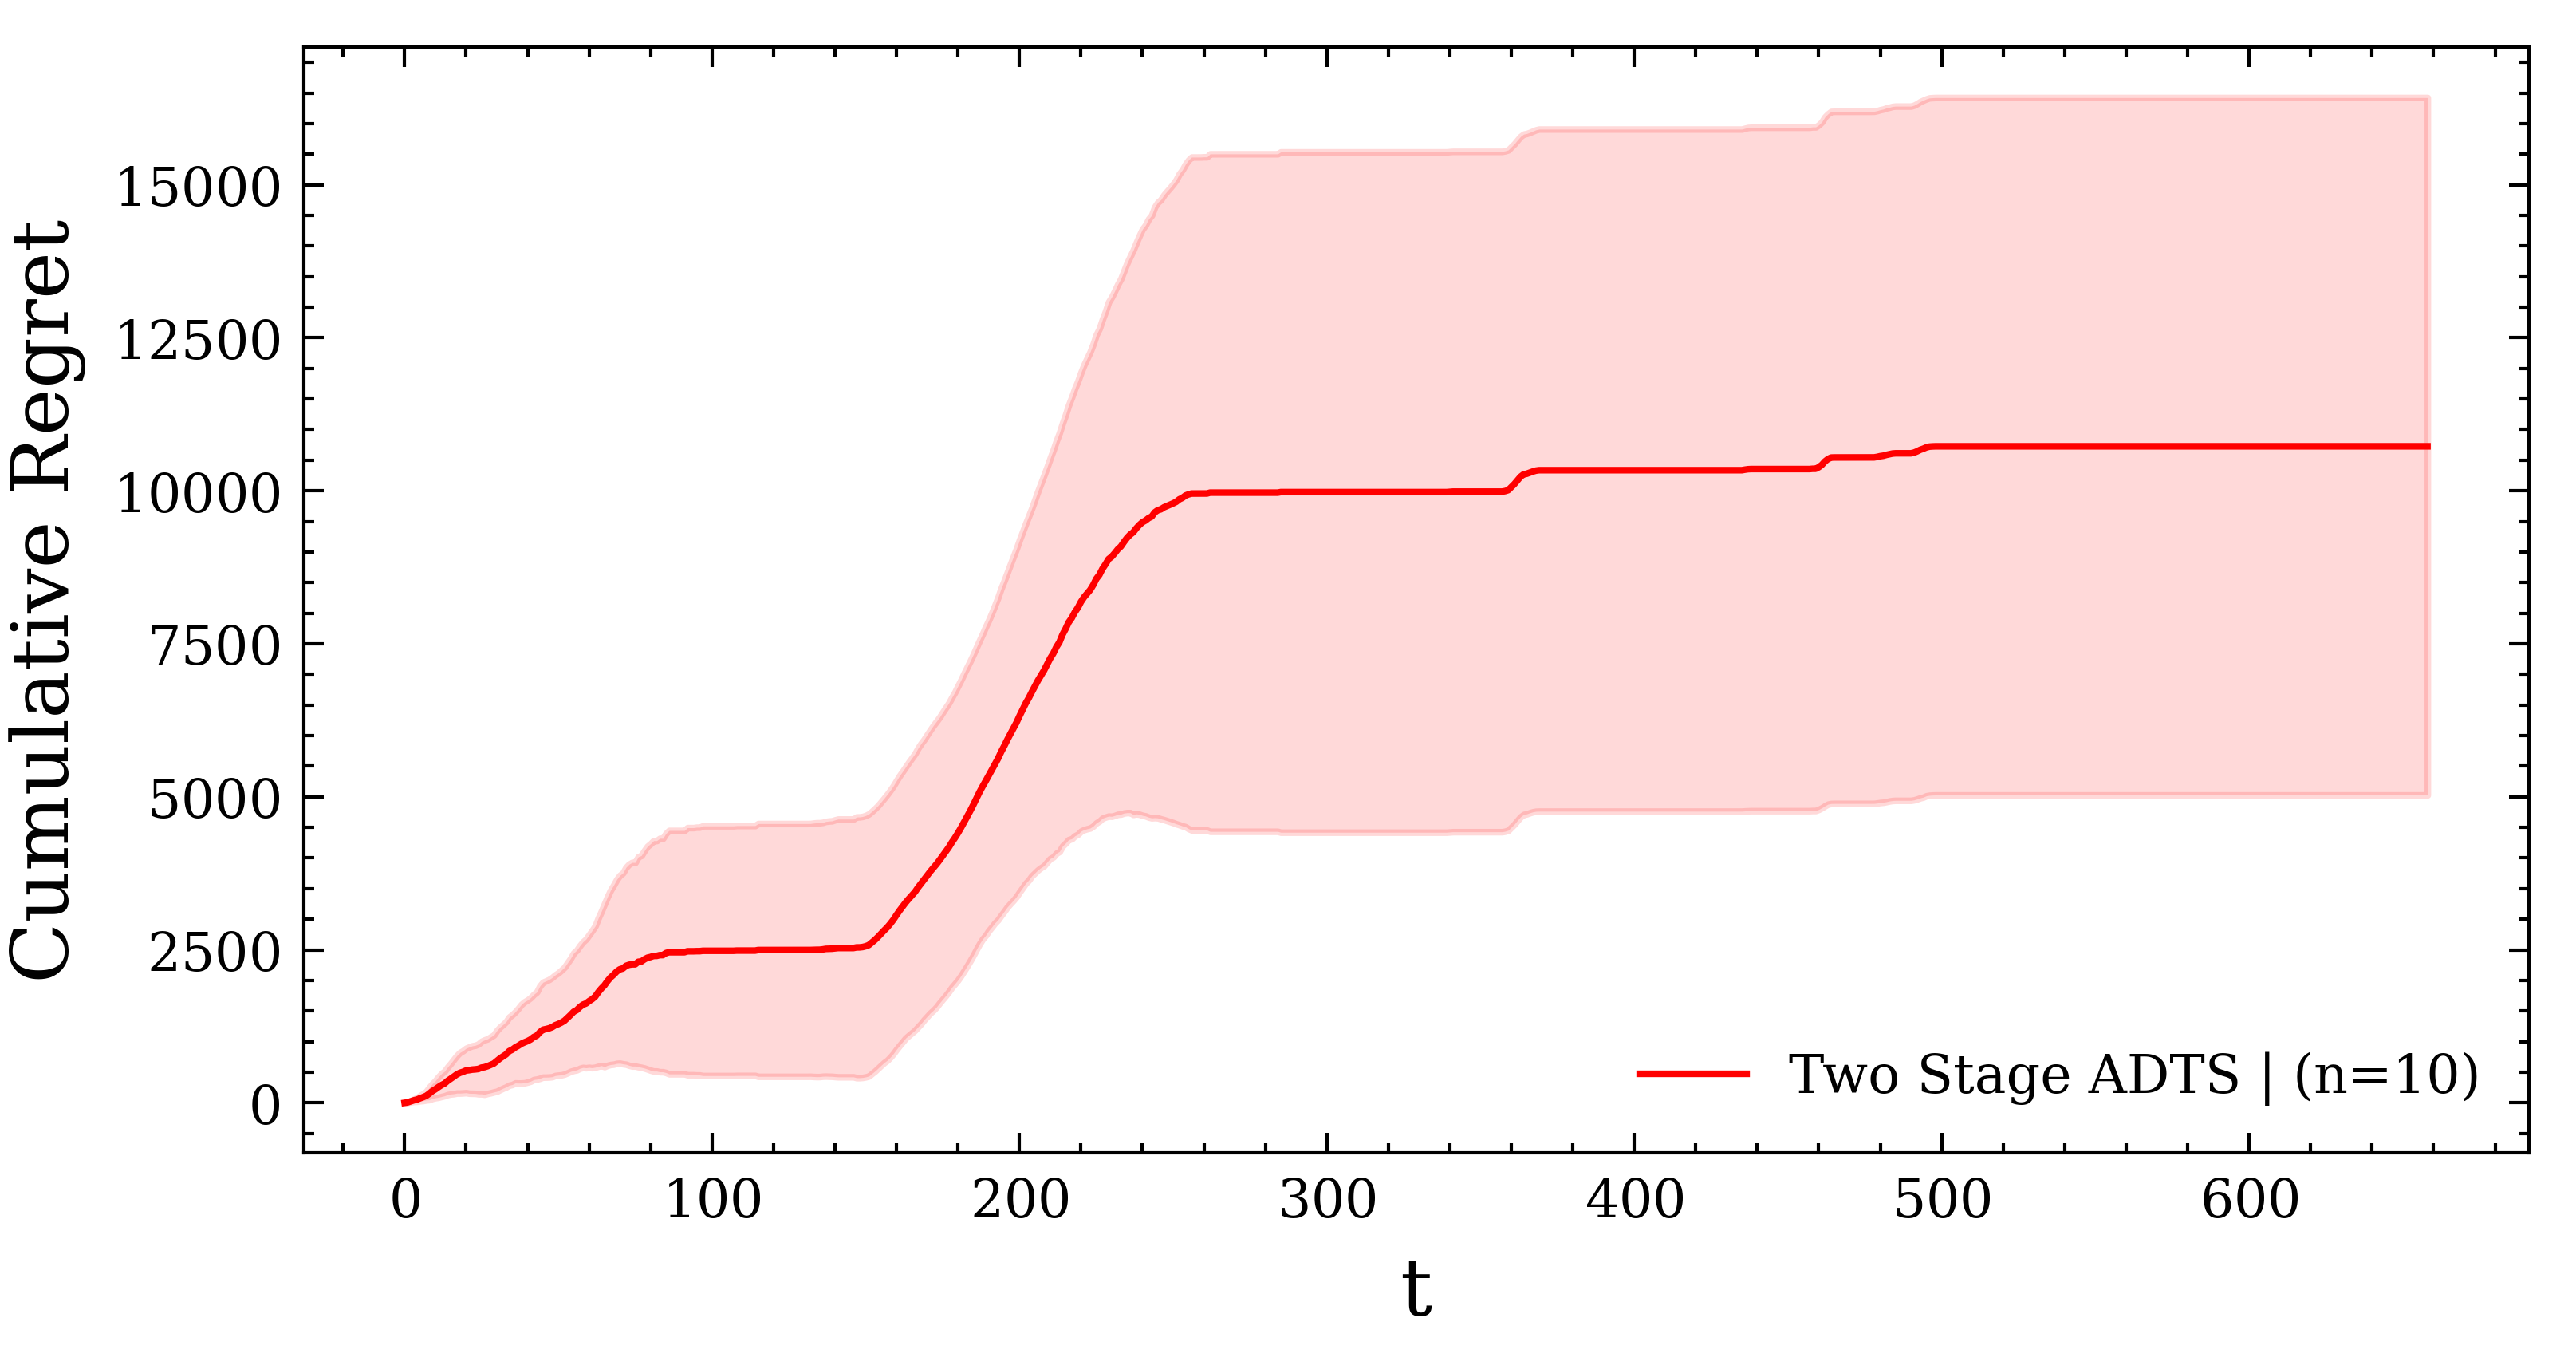

In [131]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    i = 0
    for policy, output in bandit_policies.items():
        plt.plot(np.cumsum(output["mean_regret"]), color=colors[i].rgb)
        confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
        upper = np.cumsum(output["mean_regret"] + confidence_interval)
        lower = np.cumsum(output["mean_regret"] - confidence_interval)
        plt.fill_between(list(range(len(output["mean_regret"]))), upper, lower, color=colors[i].rgb, alpha=0.15, label='_nolegend_')
        i += 1
    plt.legend([p for p in bandit_policies.keys()])
    plt.xlabel('t', fontsize=12)
    plt.ylabel('Cumulative Regret', fontsize=12)
    # plt.yscale('log')
#     plt.grid(True)
    plt.savefig('02_cumulative_regrets.jpg', dpi=600)

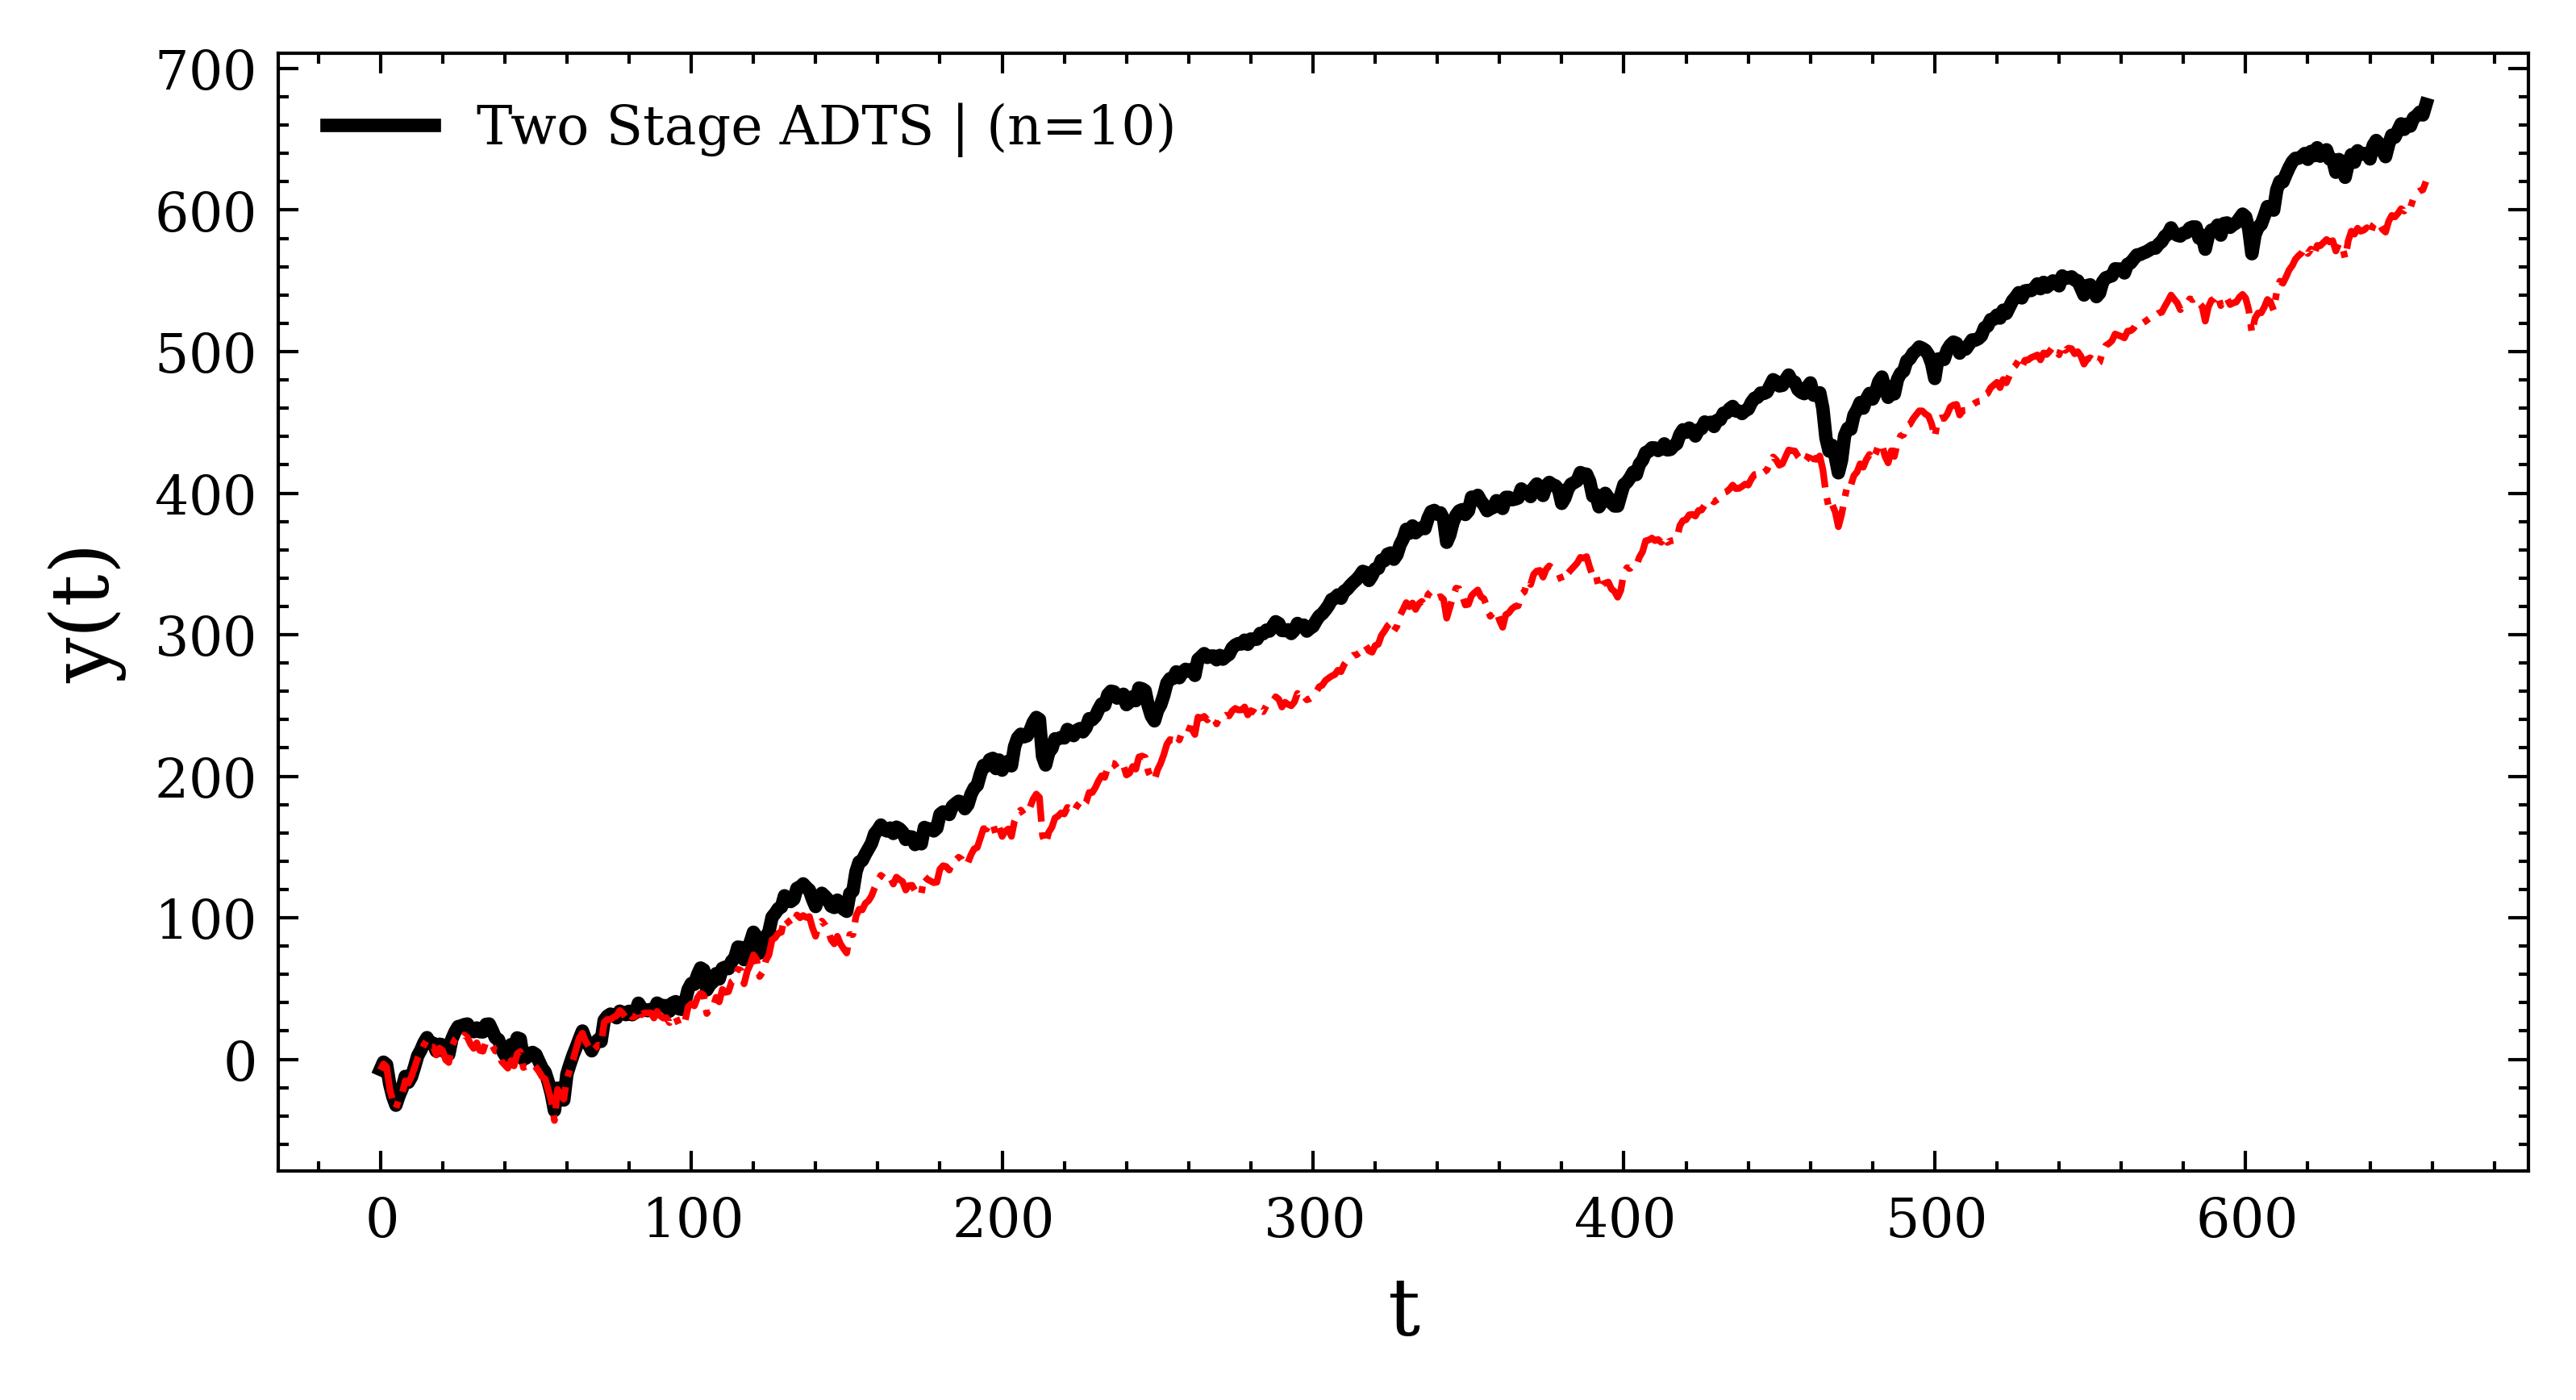

In [132]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    oracle = portfolio.mean(axis=1).cumsum()
    plt.plot(oracle.values, linewidth=2)
    legend = []#["Oracle"]
    i = 0
    for policy, output in bandit_policies.items():
        plt.plot(output["mean_reward"].cumsum(), color=colors[i].rgb, linestyle="-.")
        legend.append(policy)
        i+=1
    
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.legend(legend)
    # plt.savefig('03_rewards_versus_oracle.jpg', dpi=600)

In [122]:
# robustness_dict = {}
bandit_policies
dropped_stocks = []
n_sim = 10

# df_sp = retrieve_sp_returns()

portfolio_copy = portfolio.copy()

for i in range(10):
    total_returns = portfolio_copy.sum(axis=0).sort_values(ascending=False)
    df_classical = calculate_classical_portfolios(portfolio=portfolio_copy)
    
    bandit_policies = run_naive_bandit_network(portfolio=portfolio_copy, n_sim=n_sim, n_super_arms=4)
    bandit_policies.update(
        run_naive_bandit_network(portfolio=portfolio_copy, n_sim=n_sim, n_super_arms=10)
    )
    bandit_policies.update(
        run_naive_bandit_network(portfolio=portfolio_copy, n_sim=n_sim, n_super_arms=15)
    )
    bandits_boxplot_dict = collect_box_plot_values(bandit_policies=bandit_policies)
    policies = bandit_policies.copy()
    df_classical = calculate_classical_portfolios(portfolio=portfolio_copy)
    for col in df_classical.columns:
        policies[col] = {
            "mean_reward": df_classical[col].values
        }
    # policies["S&P 500"] = {
    #     "mean_reward": df_sp["^GSPC"].values
    # }
    df_results = aggregate_metrics(policies=policies)
    
    
    # robustness_dict[i] = {
    #     "df_results": df_results,
    #     "dropped_stocks": dropped_stocks,
    #     "bandits_boxplot_dict": bandits_boxplot_dict
    # }
    # prev_total_stocks = len(portfolio.columns)
    # pop_best = total_returns.index[0]
    # portfolio_copy = portfolio_copy.drop(columns=[pop_best])
    # dropped_stocks.append(pop_best)
    # print(f"Removing stock {pop_best} from search space")
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


NameError: name 'calculate_classical_portfolios' is not defined

In [36]:
import pickle

with open('robustness_dict.pkl', 'wb') as f:
    pickle.dump(robustness_dict, f)

In [11]:
import pickle
with open('robustness_dict.pkl', 'rb') as f:
    robustness_dict = pickle.load(f)

In [12]:
robustness_dict

{0: {'df_results':                                  Cumulative Returns  Sharpe Ratio  Drawdown  \
  Two Stage RF-DSW TS | (n=4)                4.918547      1.585444 -0.898278   
  SW UCB | C RF-DSW TS | (n=4)               4.730151      1.370397 -1.779562   
  RF-DSW TS | C RF-DSW TS | (n=4)            3.817295      1.297331 -1.696671   
  Two Stage RF-DSW TS | (n=10)               2.609225      1.472653 -0.714985   
  Two Stage RF-DSW TS | (n=15)               2.552334      1.579542 -0.549254   
  CAPM                                       1.786286      1.289669 -0.689908   
  Equal Weights                              1.594225      1.318586 -0.588752   
  Risk Parity                                1.382911      1.314168 -0.499763   
  S&P 500                                    1.280474      1.173726 -0.493637   
  Markowitz                                  0.148788      0.401622 -0.221753   
  
                                   Win Rate  Sortino Ratio  
  Two Stage RF-DSW TS | (n=4

In [13]:
inverted_dict = {}

for key in robustness_dict.keys():
    bp_dict = robustness_dict[key]['bandits_boxplot_dict']
    for policy, results_dict in bp_dict.items():
        for metric_name, metric_list in results_dict.items():
            if metric_name not in inverted_dict.keys():
                inverted_dict[metric_name] = {}
            if policy not in inverted_dict[metric_name].keys():
                inverted_dict[metric_name][policy] = {}
            if key not in inverted_dict[metric_name][policy].keys():
                inverted_dict[metric_name][policy][key] = metric_list
                continue
            inverted_dict[metric_name][policy][key] = metric_list

In [ ]:
from colour import Color

red = Color("red", luminance=0.5)
colors = list(red.range_to(Color("blue", luminance=0.3), 3))


for metric_name, policy_dict in inverted_dict.items():
    fig = plt.figure(figsize =(12, 4))
    ax = fig.add_subplot(111)
    k = 0
    for policy_name, results_dict in policy_dict.items():
        bp_data = []
        drop_stocks_list = []
        for i, metric_list in results_dict.items():
            bp_data.append(metric_list)
            drop_stocks_list.append(i)
            
        bp = ax.boxplot(bp_data, patch_artist = True)
#         ax.xlabel("Number of Top Stocks Dropped")
        
        for patch in bp['boxes']:
            patch.set_facecolor(colors[k].rgb)
        
        for median in bp['medians']:
            median.set(color='black',
                       linewidth=1)
        k += 1
        

In [14]:
from colour import Color

red = Color("red", luminance=0.5)
colors = list(red.range_to(Color("blue", luminance=0.3), 5))


display_results_dict = {
    "Two Stage RF-DSW TS | (n=4)": {
        "display": True,
        "color": colors[0].rgb,
        "linestyle": "-"
    },
    "Two Stage RF-DSW TS | (n=10)": {
        "display": True,
        "color": colors[1].rgb,
        "linestyle": "-"
    },
    "Two Stage RF-DSW TS | (n=15)": {
        "display": True,
        "color": colors[2].rgb,
        "linestyle": "-"
    },
    "SW UCB | C RF-DSW TS | (n=4)": {
        "display": True,
        "color": colors[3].rgb,
        "linestyle": "-"
    },
    "RF-DSW TS | C RF-DSW TS | (n=4)": {
        "display": True,
        "color": colors[4].rgb,
        "linestyle": "-"
    },
    "CAPM": {
        "display": True,
        "color": 'orange',
        "linestyle": "-."
    },
    "S&P 500": {
        "display": True,
        "color": 'k',
        "linestyle": "--"
    },
}

In [15]:
robustness_dict[2]["dropped_stocks"]

['NVDA', 'AVGO', 'TSLA', 'LLY', 'GE', 'AMD', 'AAPL', 'XOM', 'GOOG', 'QCOM']

Two Stage RF-DSW TS (n=4) & 4.92 & 1.75 & 1.16 & 76.4\%  \\
SW UCB C RF-DSW TS (n=4) & 4.73 & 1.37 & 1.24 & 73.8\%  \\
RF-DSW TS C RF-DSW TS (n=4) & 3.82 & 1.14 & 0.64 & 83.2\%  \\
Two Stage RF-DSW TS (n=10) & 2.61 & 1.27 & 1.24 & 52.5\%  \\
Two Stage RF-DSW TS (n=15) & 2.55 & 1.51 & 1.41 & 44.7\%  \\
CAPM & 1.79 & 1.33 & 1.18 & 33.900000000000006\%  \\
S&P 500 & 1.28 & 1.28 & 1.28 & 0.0\%  \\


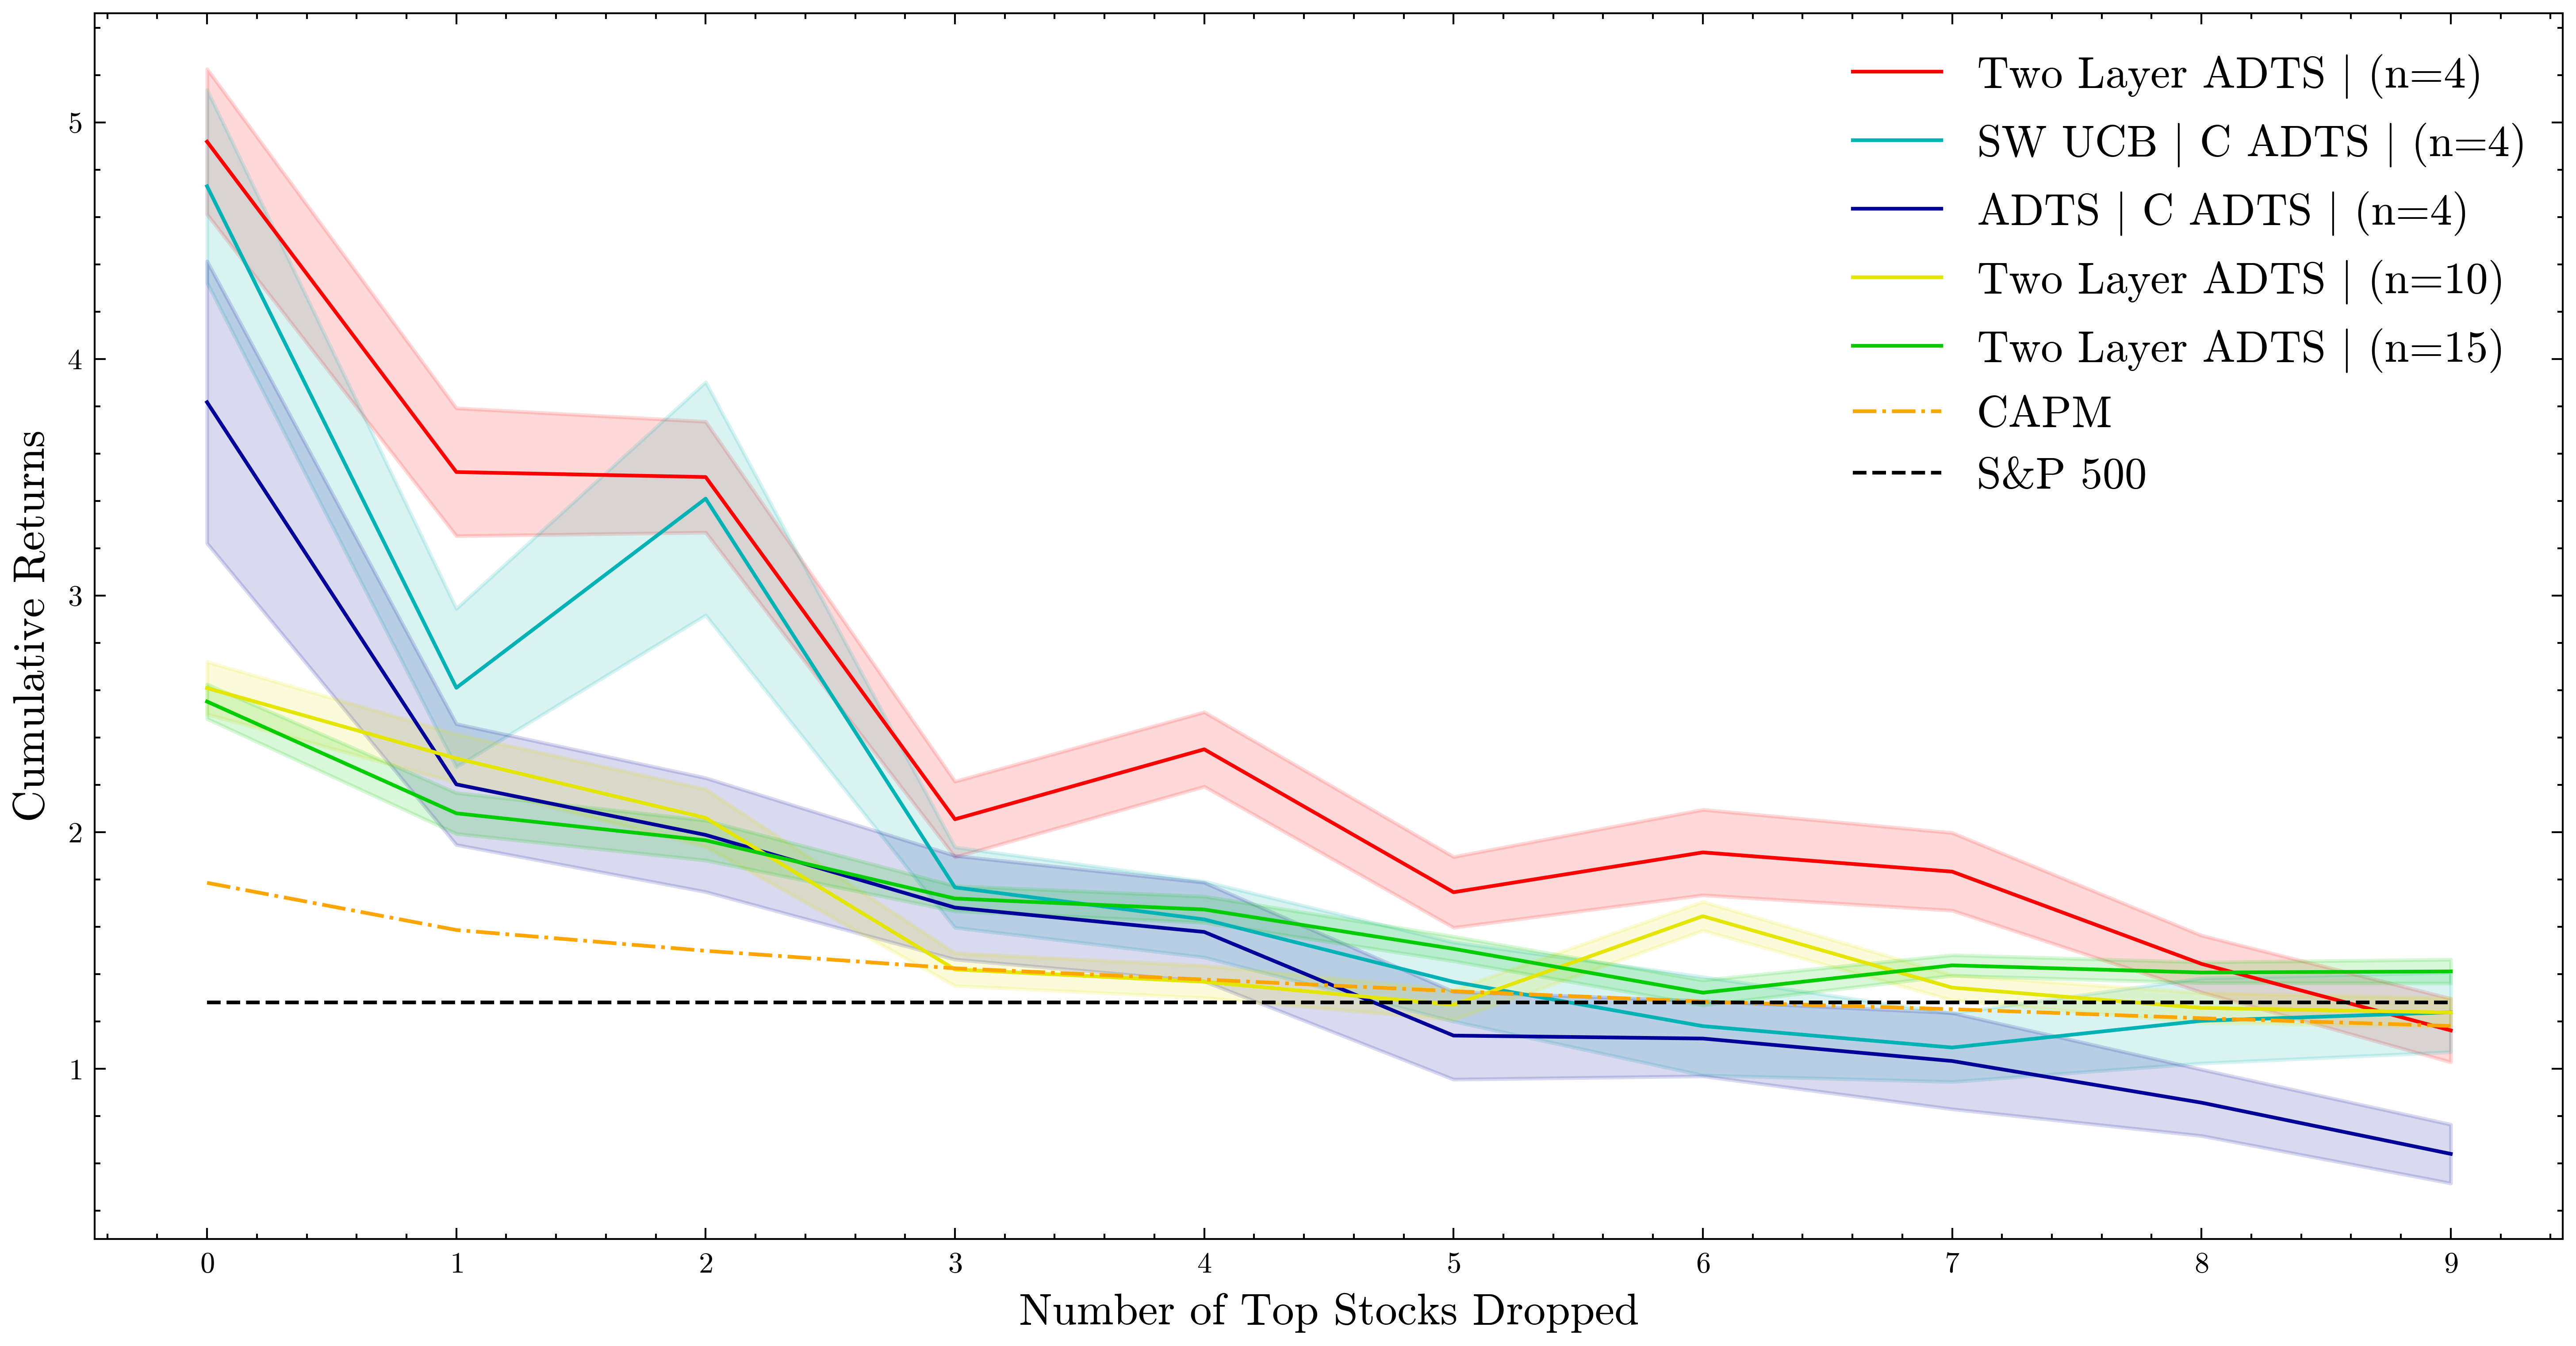

Two Stage RF-DSW TS (n=4) & 1.59 & 1.09 & 0.89 & 43.6\%  \\
SW UCB C RF-DSW TS (n=4) & 1.37 & 0.86 & 0.89 & 35.099999999999994\%  \\
RF-DSW TS C RF-DSW TS (n=4) & 1.3 & 0.86 & 0.62 & 52.2\%  \\
Two Stage RF-DSW TS (n=10) & 1.47 & 1.07 & 1.1 & 25.6\%  \\
Two Stage RF-DSW TS (n=15) & 1.58 & 1.26 & 1.27 & 19.8\%  \\
CAPM & 1.29 & 1.13 & 1.08 & 16.1\%  \\
S&P 500 & 1.17 & 1.17 & 1.17 & 0.0\%  \\


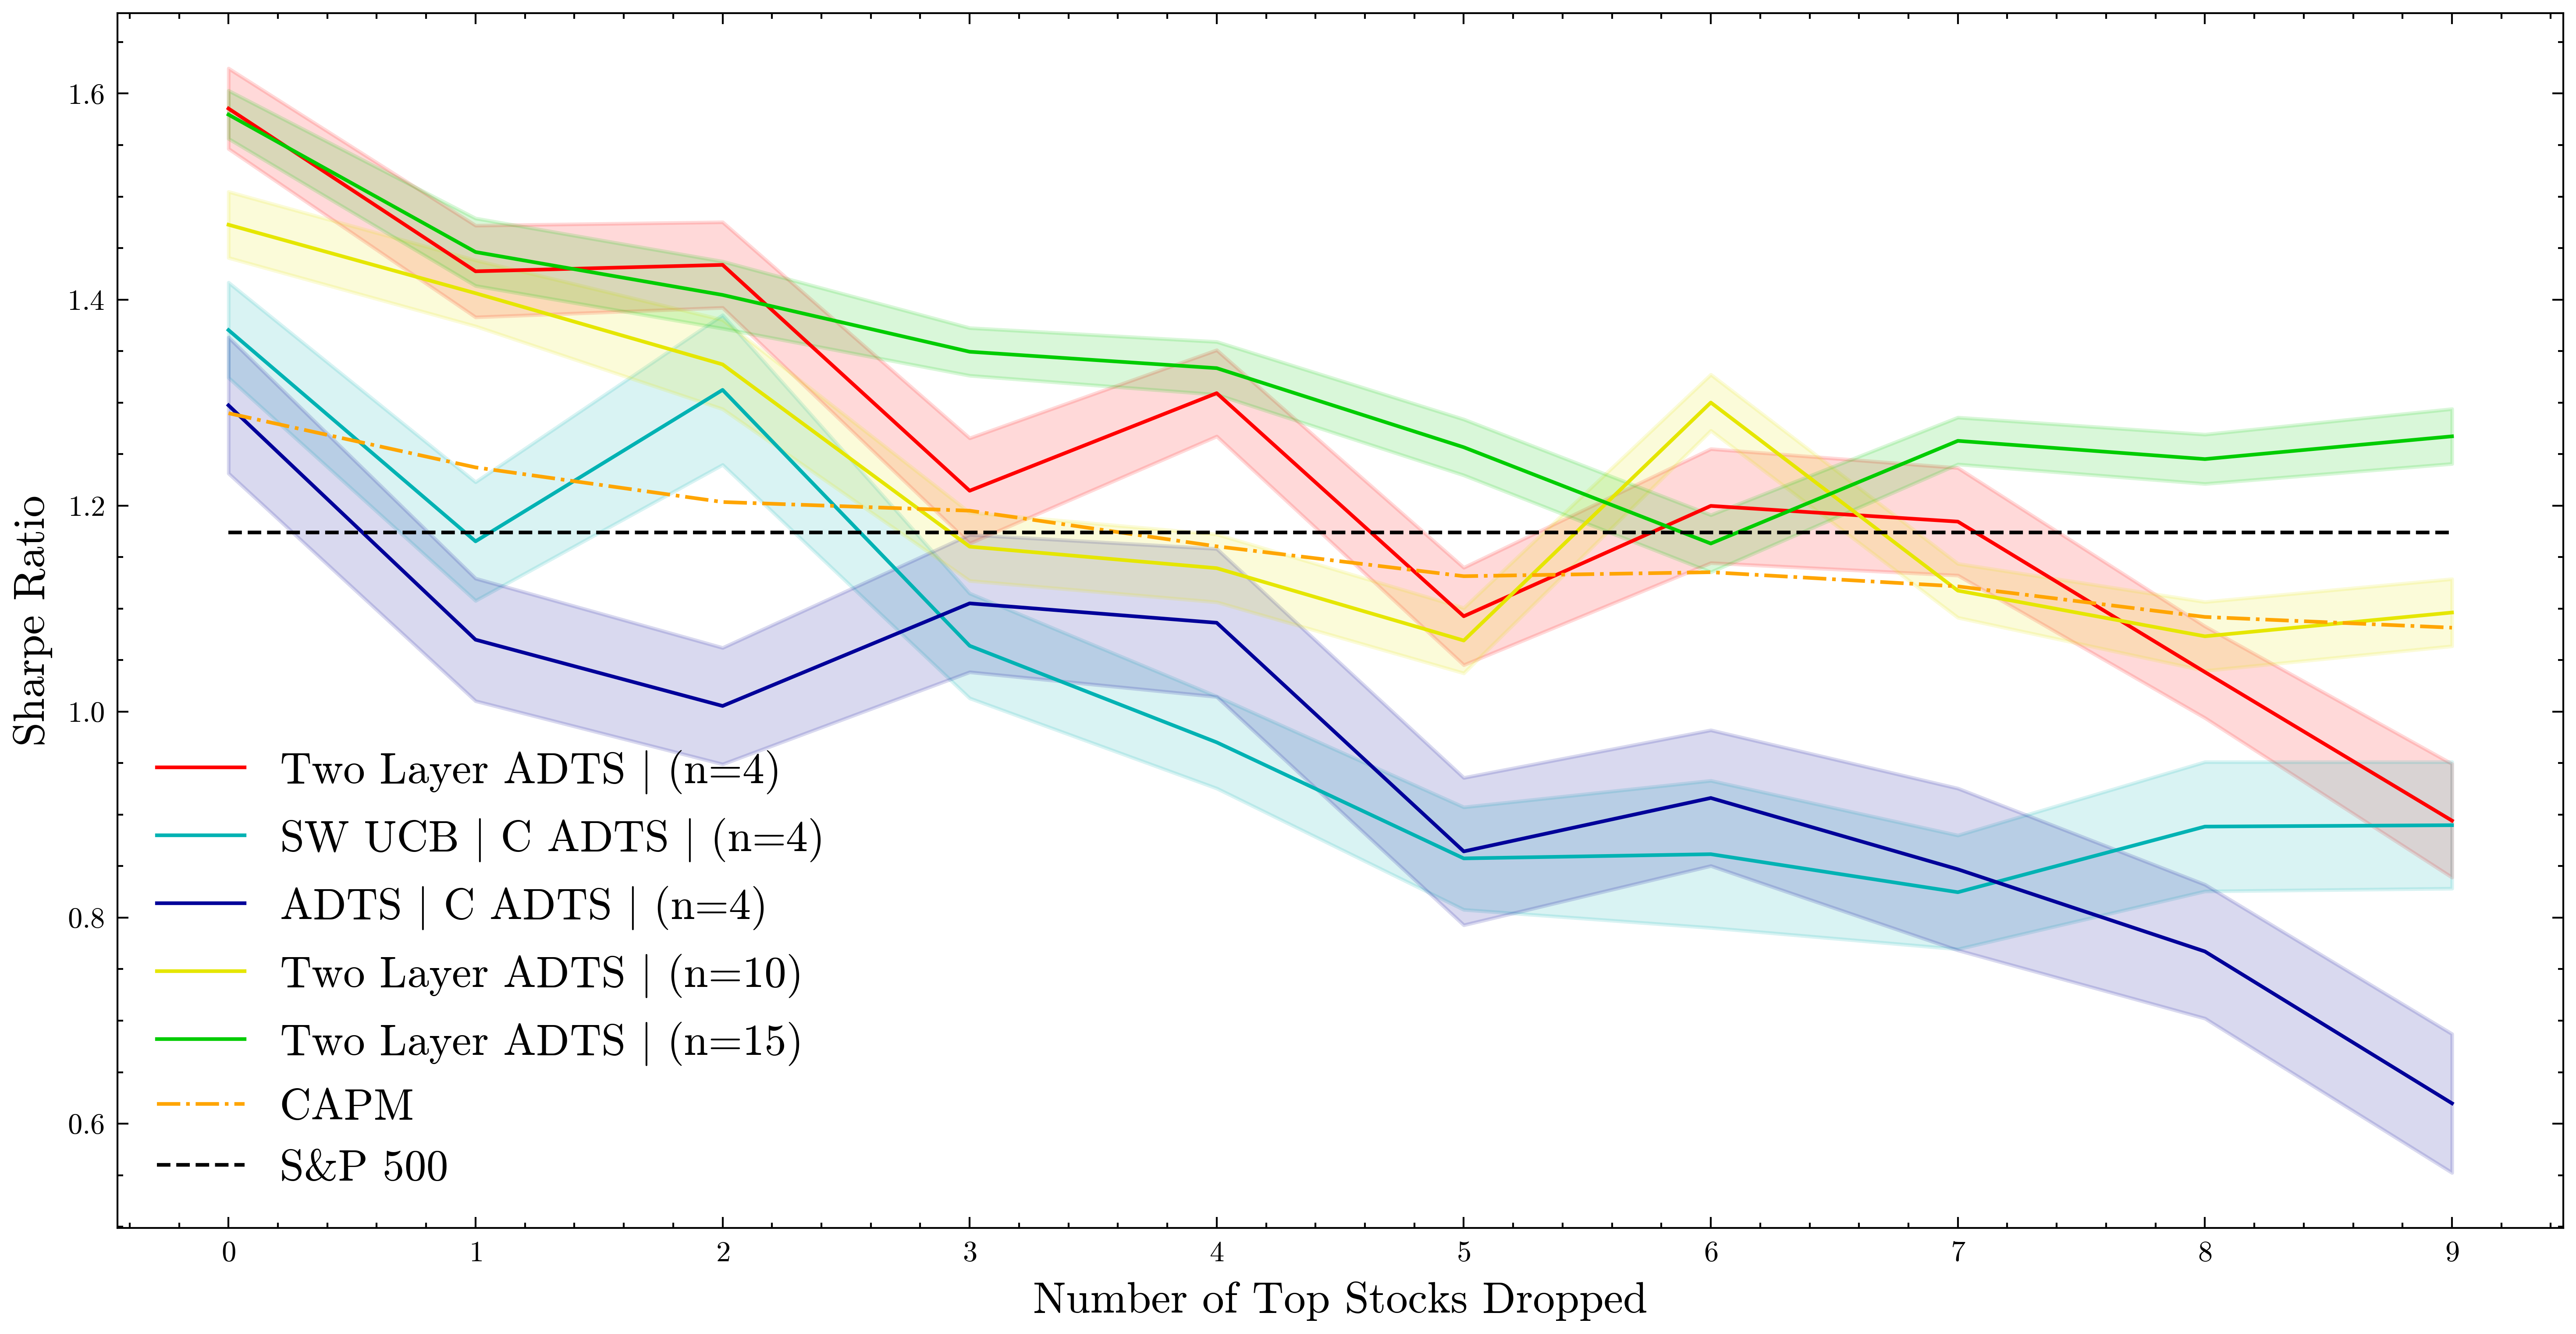

Two Stage RF-DSW TS (n=4) & -0.9 & -0.56 & -0.55 & 38.800000000000004\%  \\
SW UCB C RF-DSW TS (n=4) & -1.78 & -0.78 & -0.57 & 68.10000000000001\%  \\
RF-DSW TS C RF-DSW TS (n=4) & -1.7 & -0.6 & -0.59 & 65.5\%  \\
Two Stage RF-DSW TS (n=10) & -0.71 & -0.45 & -0.45 & 37.4\%  \\
Two Stage RF-DSW TS (n=15) & -0.55 & -0.42 & -0.34 & 38.9\%  \\
CAPM & -0.69 & -0.59 & -0.57 & 17.299999999999997\%  \\
S&P 500 & -0.49 & -0.49 & -0.49 & 0.0\%  \\


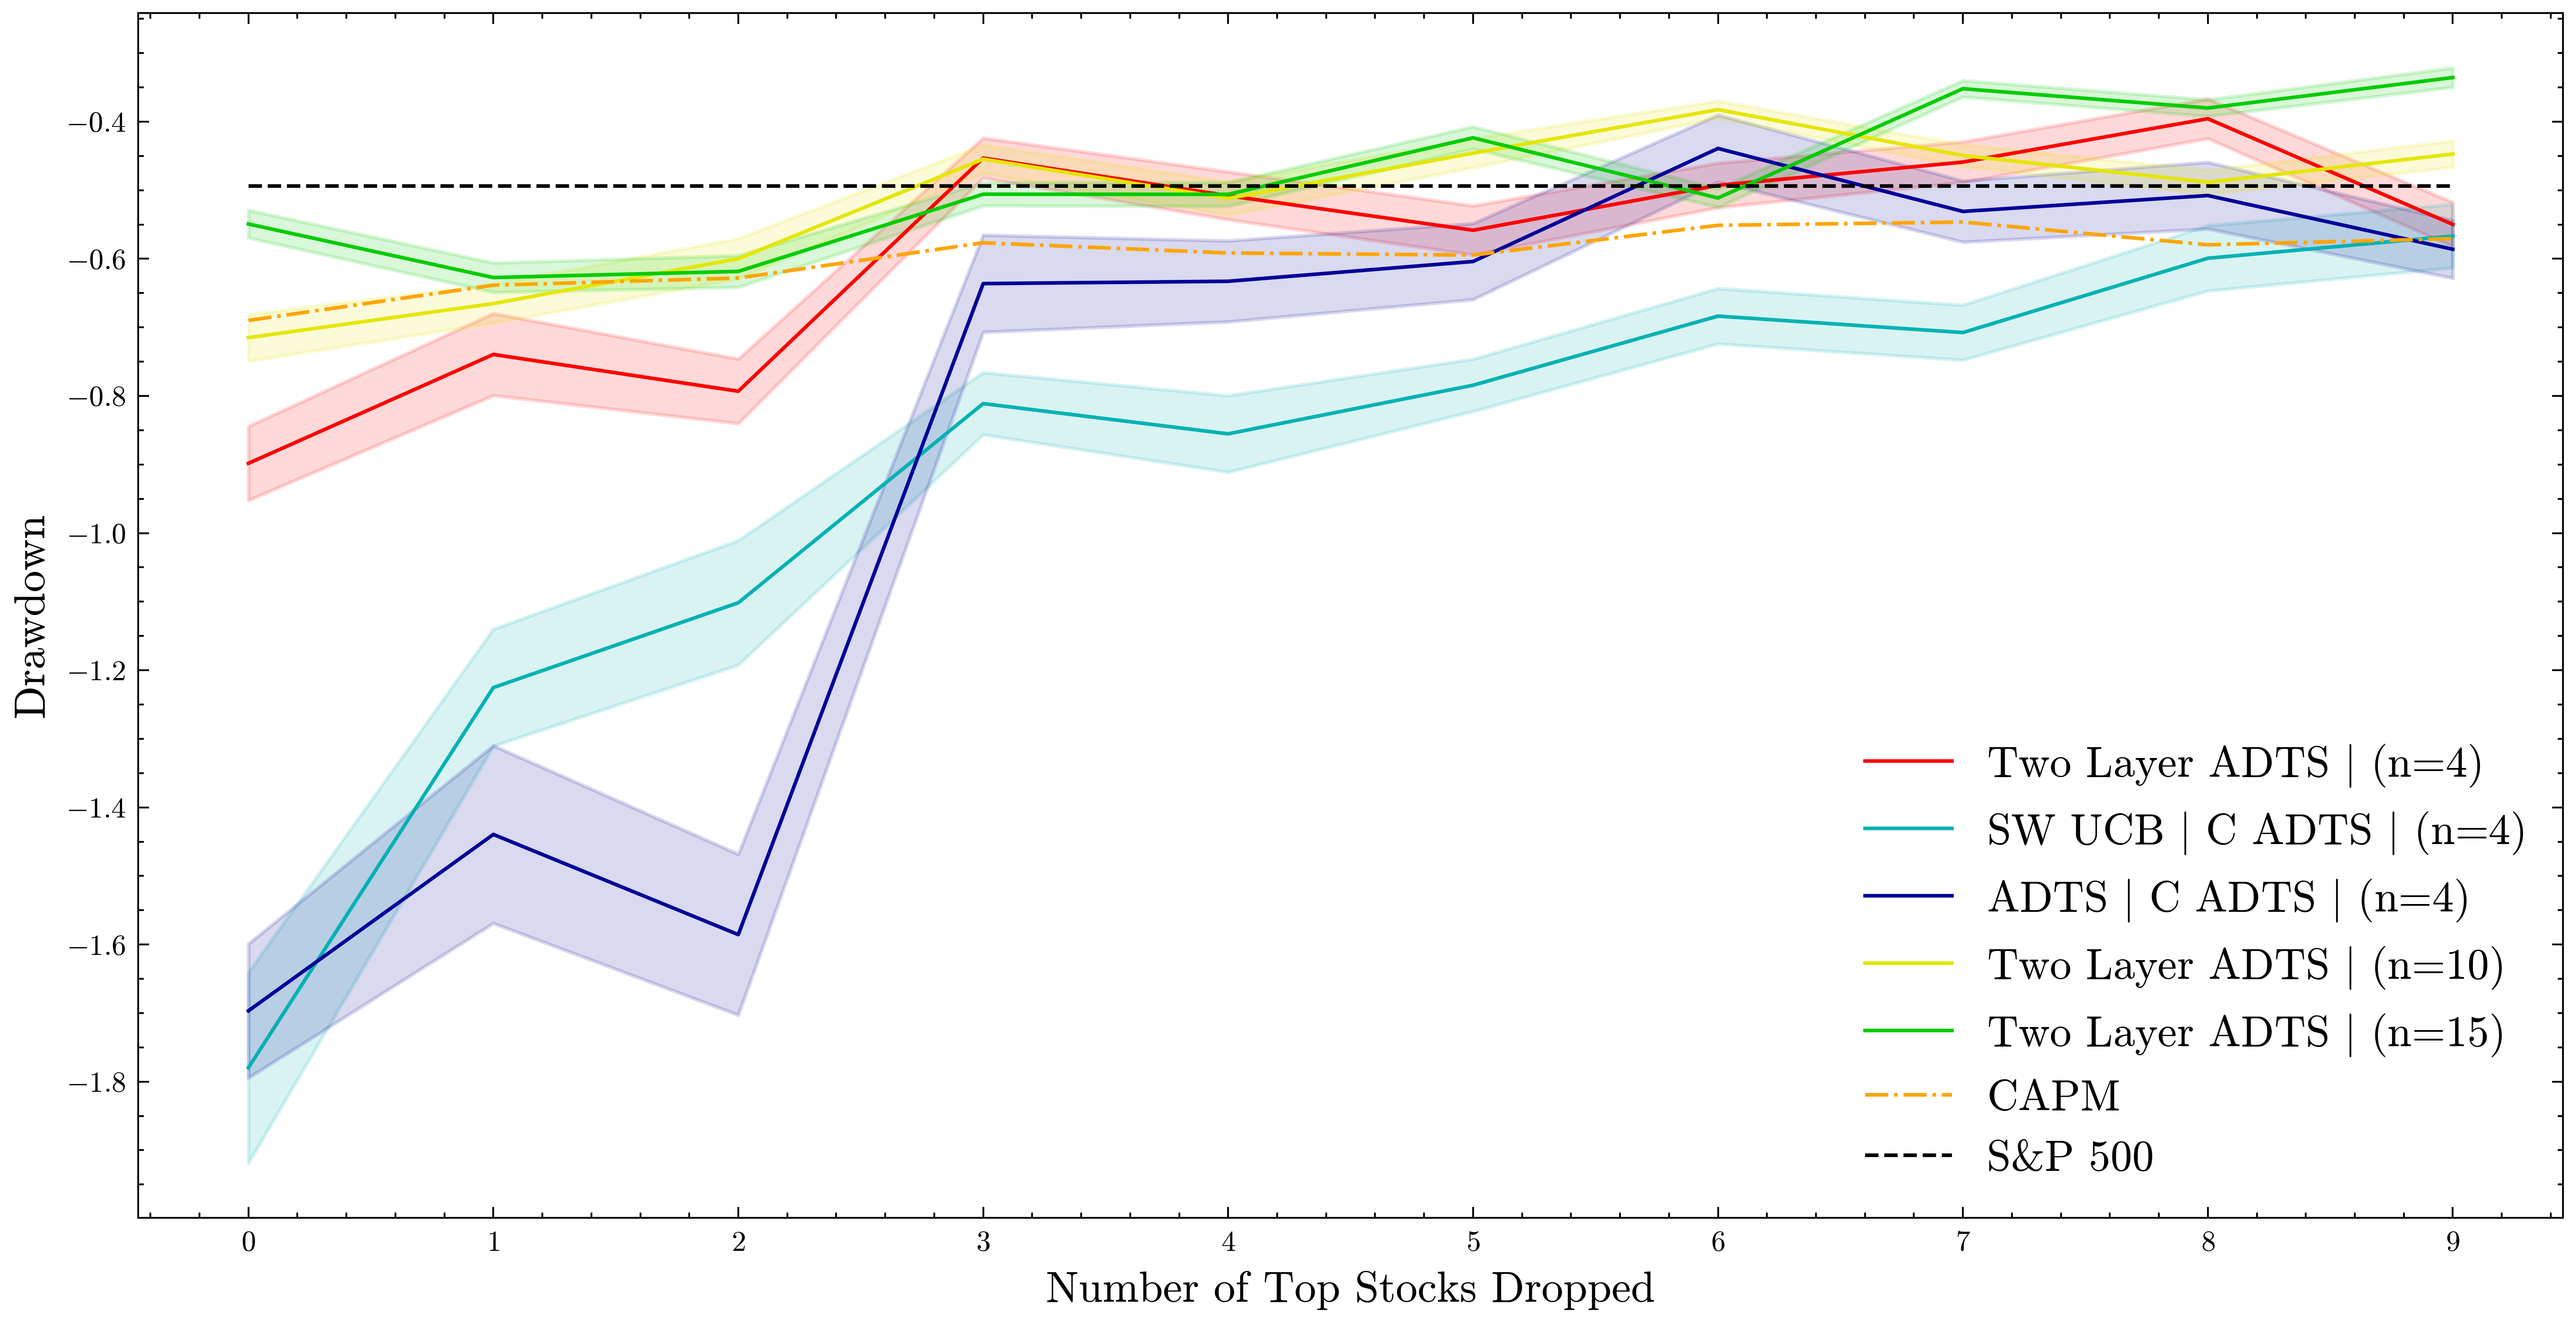

Two Stage RF-DSW TS (n=4) & 0.55 & 0.56 & 0.54 & 3.2\%  \\
SW UCB C RF-DSW TS (n=4) & 0.55 & 0.54 & 0.53 & 3.6999999999999997\%  \\
RF-DSW TS C RF-DSW TS (n=4) & 0.56 & 0.54 & 0.53 & 5.4\%  \\
Two Stage RF-DSW TS (n=10) & 0.56 & 0.55 & 0.55 & 0.7000000000000001\%  \\
Two Stage RF-DSW TS (n=15) & 0.56 & 0.55 & 0.55 & 1.5\%  \\
CAPM & 0.55 & 0.54 & 0.53 & 3.6999999999999997\%  \\
S&P 500 & 0.54 & 0.54 & 0.54 & 0.0\%  \\


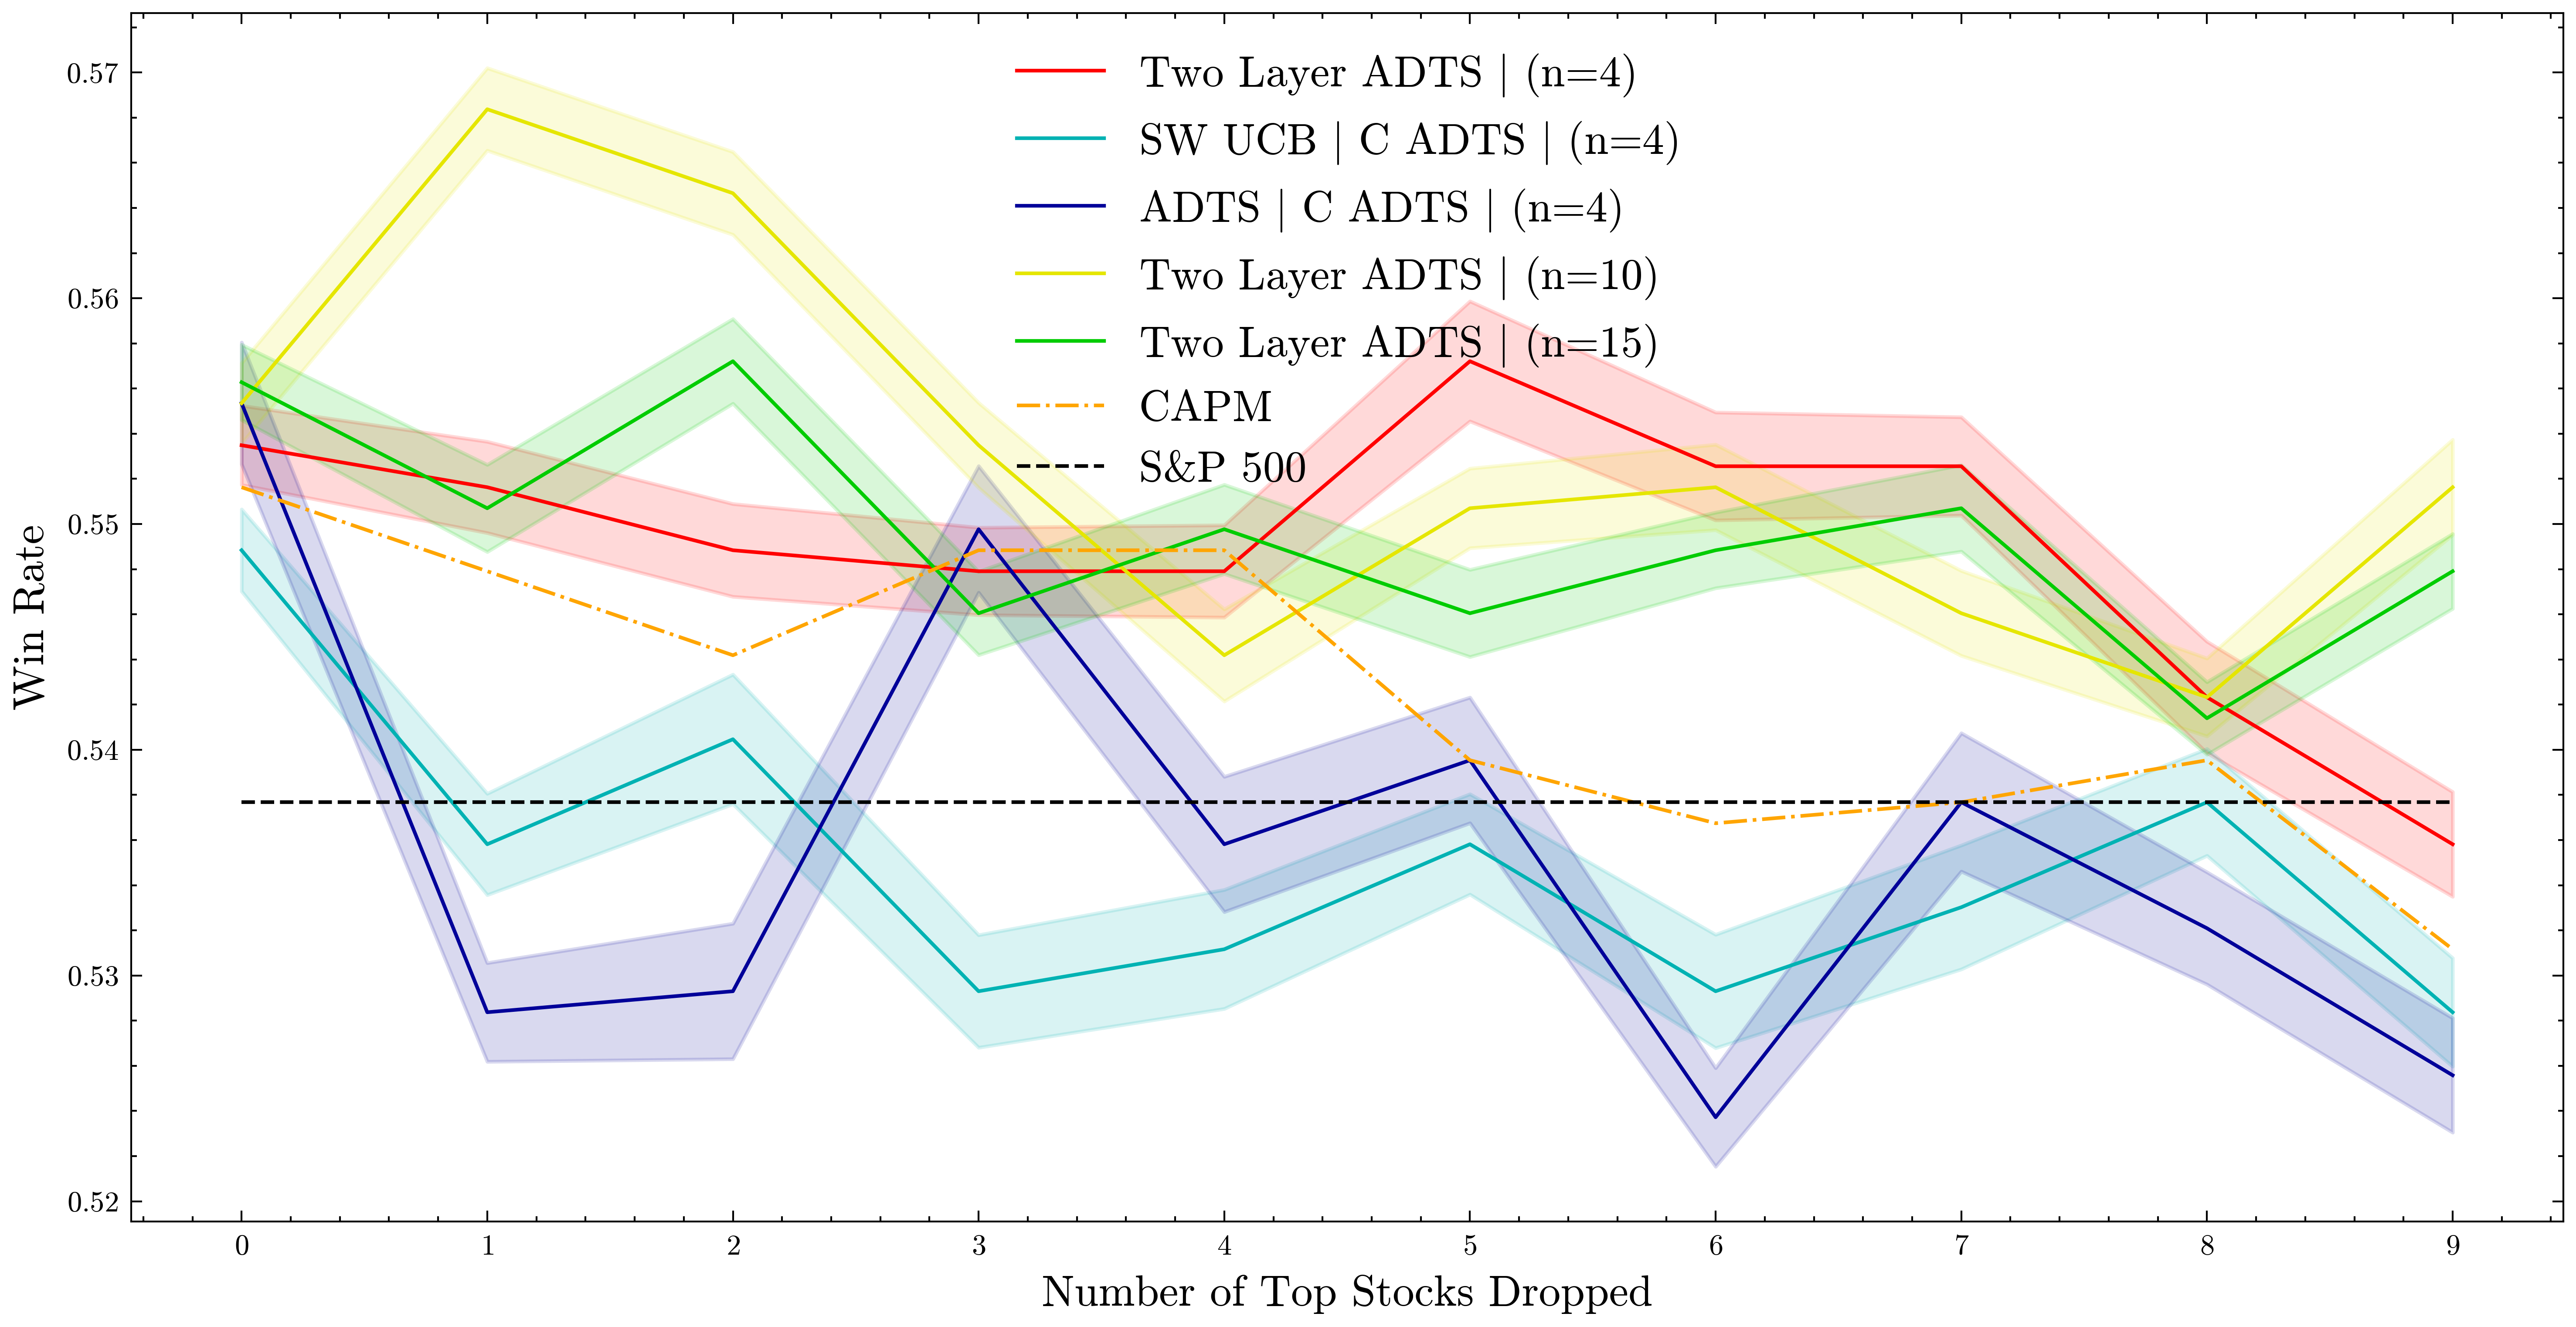

Two Stage RF-DSW TS (n=4) & 0.14 & 0.1 & 0.08 & 43.5\%  \\
SW UCB C RF-DSW TS (n=4) & 0.13 & 0.08 & 0.08 & 35.5\%  \\
RF-DSW TS C RF-DSW TS (n=4) & 0.12 & 0.08 & 0.06 & 52.2\%  \\
Two Stage RF-DSW TS (n=10) & 0.13 & 0.1 & 0.1 & 25.2\%  \\
Two Stage RF-DSW TS (n=15) & 0.14 & 0.11 & 0.11 & 21.3\%  \\
CAPM & 0.12 & 0.1 & 0.1 & 15.9\%  \\
S&P 500 & 0.1 & 0.1 & 0.1 & 0.0\%  \\


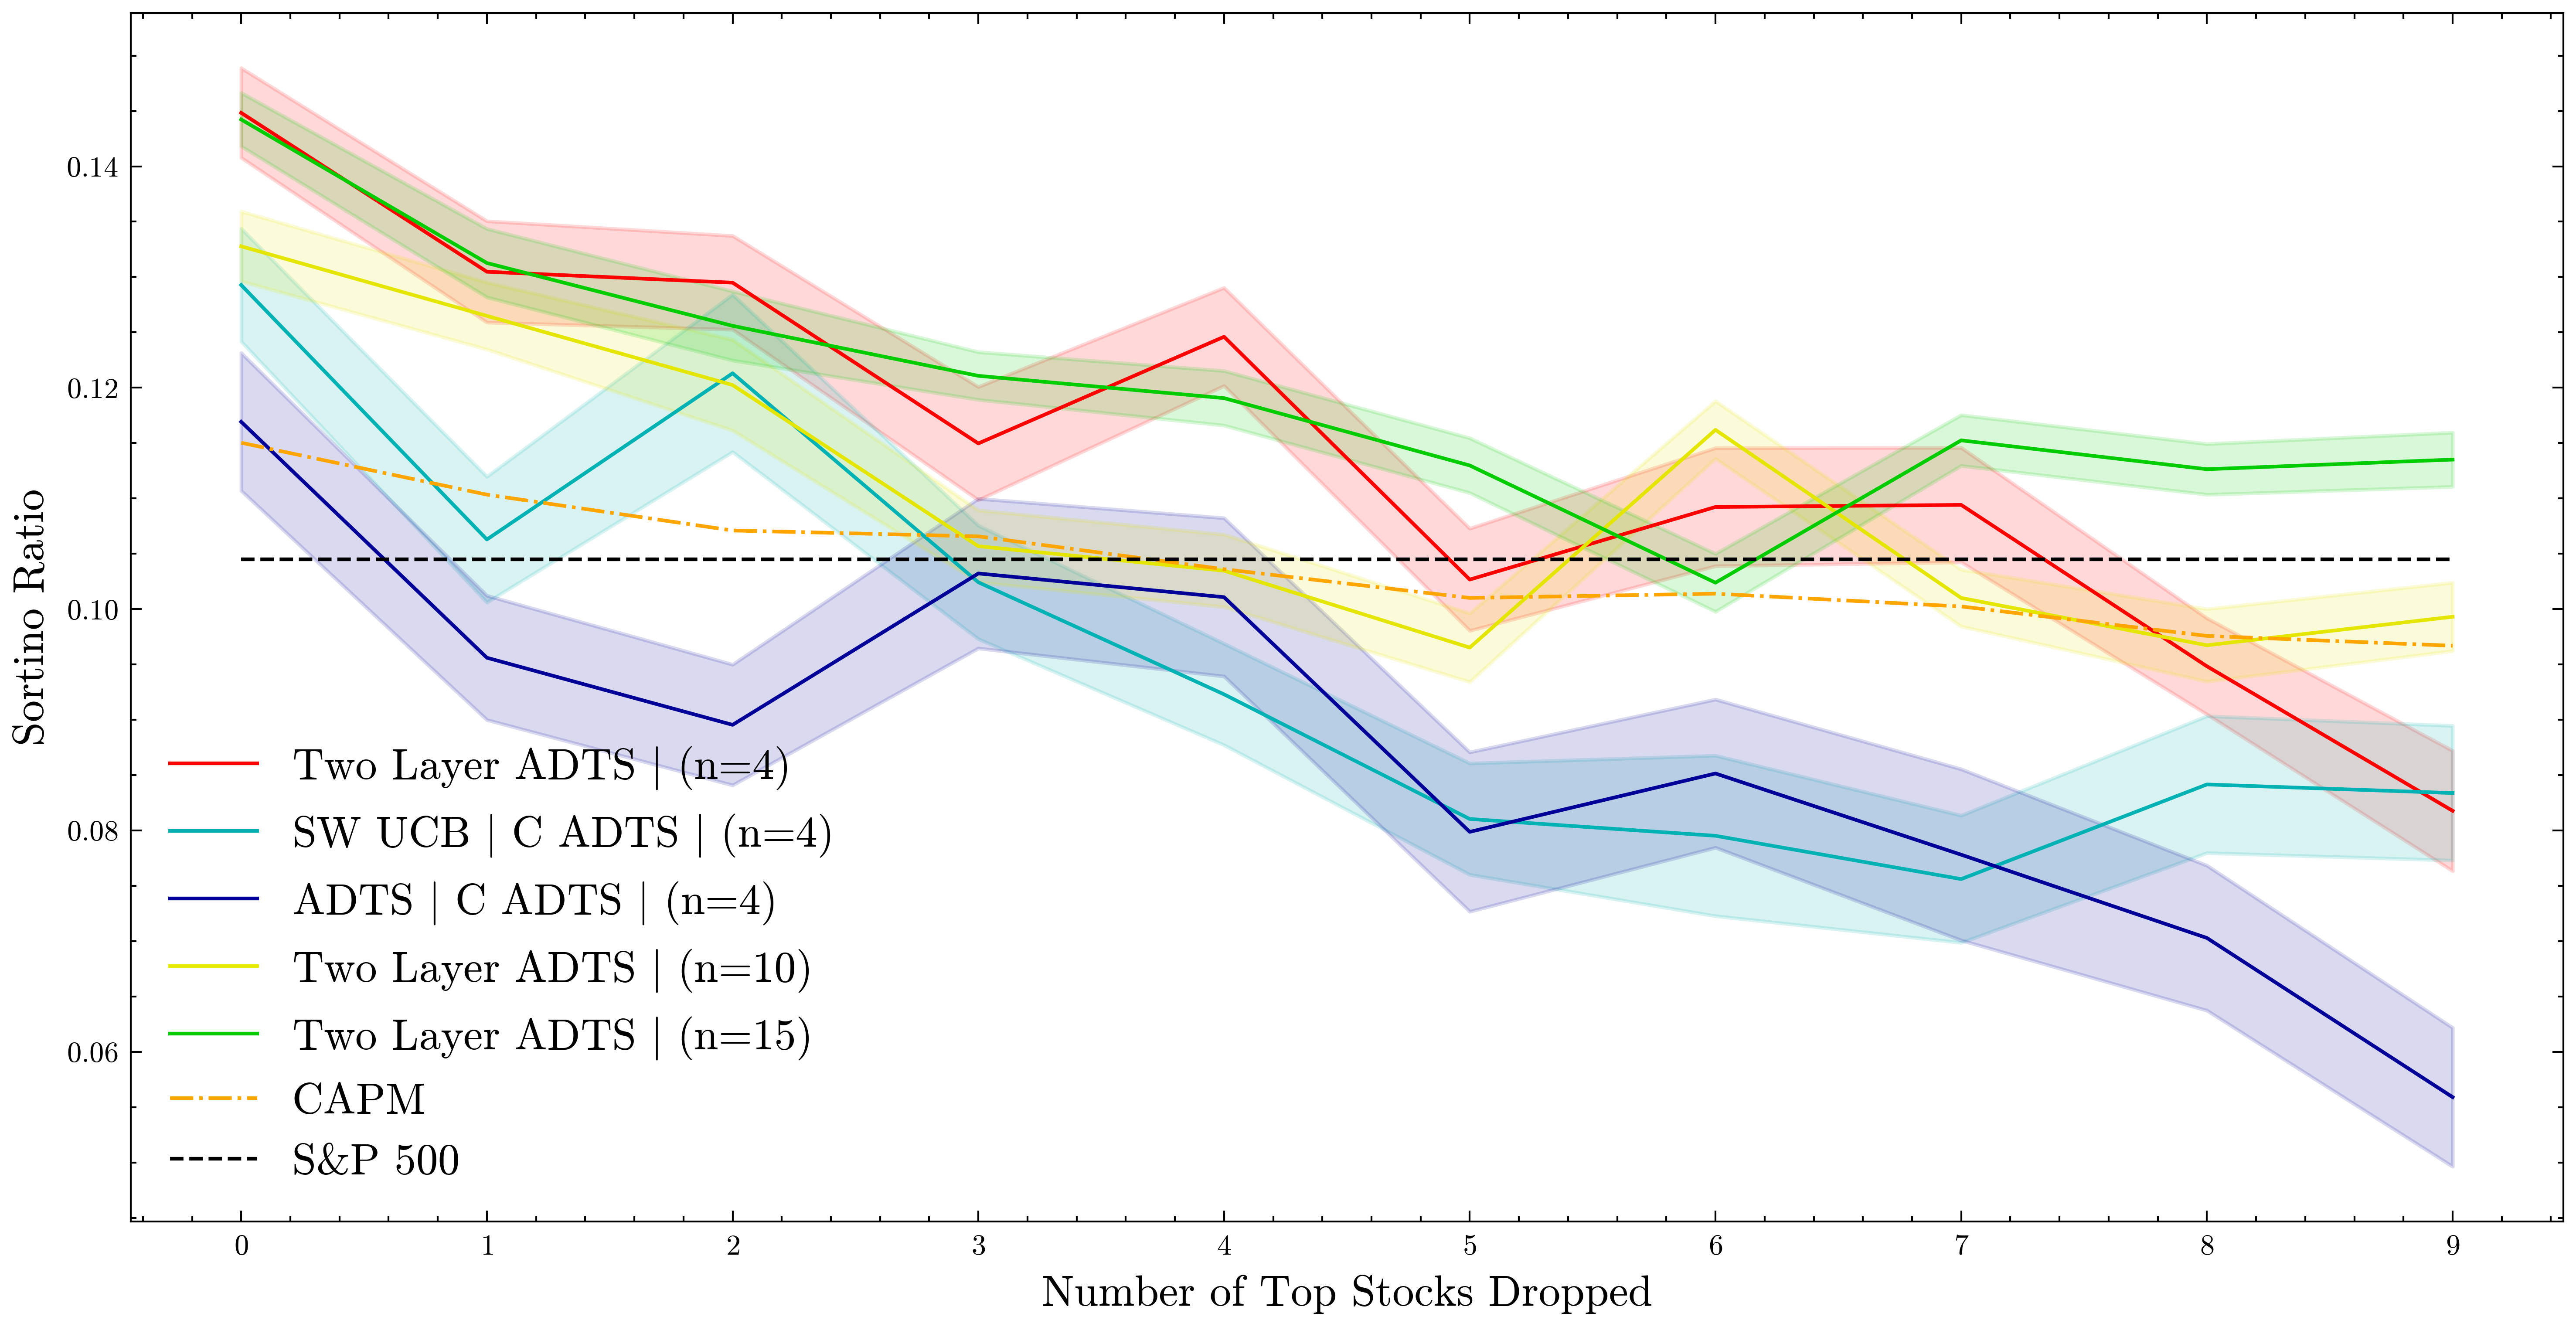

In [17]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    methodologies_dict = {}
    for i, (k, v) in enumerate(robustness_dict.items()):
        df_results = v["df_results"]
        for j in range(len(df_results)):
            methodology = df_results.index[j]
            for col in df_results.columns:
                if col not in methodologies_dict.keys():
                    methodologies_dict[col] = {
                        methodology: [df_results.loc[methodology, col]]
                    }
                else:
                    if methodology not in methodologies_dict[col].keys():
                        methodologies_dict[col][methodology] = [df_results.loc[methodology, col]]
                    else:
                        methodologies_dict[col][methodology].append(df_results.loc[methodology, col])

    for kpi in methodologies_dict.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (methodology, values) in enumerate(methodologies_dict[kpi].items()):
            if methodology in display_results_dict.keys():
                print(methodology.replace(" | ", " "), "&", round(values[0], 2), 
                      "&", round(values[5], 2), "&", round(values[-1], 2), "&", 
                      str(round(1-values[-1] / values[0], 3)*100) + "\% ", "\\\\")
                plt.plot(
                    values, 
                    label=methodology.replace("|", "$|$").replace("Stage", "Layer").replace("RF-DSW TS", "ADTS"), 
                    color=display_results_dict[methodology]["color"],
                    linestyle=display_results_dict[methodology]["linestyle"]
                )
                if methodology in inverted_dict[kpi].keys():
                    kpi_matrix = np.zeros(shape=(len(inverted_dict[kpi][methodology].keys()), len(inverted_dict[kpi][methodology][0])))
                    for j in inverted_dict[kpi][methodology].keys():
                        kpi_matrix[j, :] = inverted_dict[kpi][methodology][j]
                    confidence_interval = 1.96 * kpi_matrix.std(axis=1) / np.sqrt(kpi_matrix.shape[1])
#                     print(kpi_matrix.shape)
                    upper = (values + confidence_interval)
                    lower = (values - confidence_interval)
                    plt.fill_between(list(range(len(kpi_matrix))), upper, lower, color=display_results_dict[methodology]["color"], alpha=0.15, label='_nolegend_')
        plt.ylabel(kpi, fontsize=12)
        plt.xlabel("Number of Top Stocks Dropped", fontsize=12)
        plt.xticks(np.arange(0, 10))
#         plt.yscale('log')
        plt.legend(fontsize=12)
        plt.savefig(f'figures/problem_6_sp_market_portfolio_robustness/robustness_analysis_{kpi}.jpg', dpi=600)
        plt.show()

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_5834/2324224104.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filtered_positions[i] = x[0]
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_5834/2324224104.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filtered_velocities[i] = x[1]


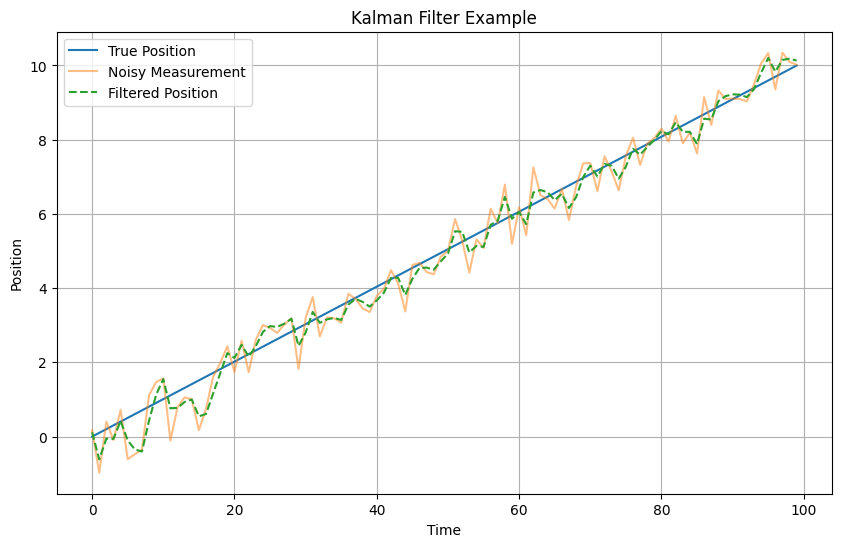

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters
dt = 1.0  # time step
A = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # measurement matrix
Q = np.array([[0.1, 0], [0, 0.1]])  # process noise covariance
R = np.array([[1]])  # measurement noise covariance

# Initial state
x_init = np.array([[0], [0]])  # initial state (position = 0, velocity = 0)

# Generate some noisy measurements
num_steps = 100
true_positions = np.linspace(0, 10, num_steps)
measurements = true_positions + np.random.normal(0, 0.5, num_steps)

# Create arrays to store the estimated states
filtered_positions = np.zeros(num_steps)
filtered_velocities = np.zeros(num_steps)

# Initialize the Kalman filter
x = x_init
P = np.eye(2)  # initial state covariance

# Kalman filter loop
for i in range(num_steps):
    # Predict
    x_pred = np.dot(A, x)
    P_pred = np.dot(np.dot(A, P), A.T) + Q

    # Update
    y = measurements[i] - np.dot(H, x_pred)
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    x = x_pred + np.dot(K, y)
    P = P_pred - np.dot(np.dot(K, H), P_pred)

    # Save the filtered state
    filtered_positions[i] = x[0]
    filtered_velocities[i] = x[1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_positions, label='True Position')
plt.plot(measurements, label='Noisy Measurement', alpha=0.5)
plt.plot(filtered_positions, label='Filtered Position', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Kalman Filter Example')
plt.legend()
plt.grid(True)
plt.show()